In [1]:
using DataFrames
using Query
using ProgressMeter
using Plots
pyplot()

include("../src/NeuroAnalysis.jl")
import NeuroAnalysis

In [3]:
_session = "ts10_V1_180422_ABABA_2"
_dir = "data/SpikeTrain"
_chart = joinpath(_dir, "CHART", _session)
isdir(_chart)||mkdir(_chart)
#_csvpath = joinpath(_dir, "SpikeTrain", "$_session.csv")
#_matpath = joinpath(_dir, "SpikeTrain", "$_session.mat")

true

In [4]:
function block_chunker(_table, _train)
    _valids = @from item in _table begin
             @where !(item.marker in ["START", "QUIT", "gray"])
             @select item
             @collect DataFrame
        end

    _shift = NeuroAnalysis.SpikeUnits.marker_validity(_valids, _train)
    _neo = DataFrame(time=_train, marker=_valids[:marker][1:end-_shift])
    _temp = _neo[1:5:end,:][:time]
    
    _chunked = Dict{String,Array{Float64,1}}("ABABA"=>_temp)
    _chunked
end

@time _spike_units, _spike_marker = NeuroAnalysis.SpikeUnits.import_spike_train_data(
    _session, "1",
    _dir = _dir,
    _chunker=block_chunker
);

  7.033495 seconds (4.78 M allocations: 249.923 MiB, 1.61% gc time)


In [5]:
nord = Dict(
    :polarnight => ("#2e3440", "#3b4252", "#434c5e", "#4c566a"),            # polar night
    :snowstorm  => ("#d8dee9", "#e5e9f0", "#eceff4"),                       # snow storm
    :frost      => ("#8fbcbb", "#88c0d0", "#81a1c1", "#5e81ac"),            # frosta
    :aurora     => ("#bf616a", "#d08770", "#ebcb8b", "#a3be8c", "#b48ead")  # aurora
);

In [88]:
roi = -5:0.1:20
backgrounds = -4:0.1:-1
pbar = Progress(length(_spike_units), dt=1)
for (channel, spike) in _spike_units
    _train = spike.spike_train
    k = NeuroAnalysis.LinearFilter.gaussian_kernel(_train, 0.4);
    dx = NeuroAnalysis.LinearFilter.apply_roi_aggregate(k, _spike_marker.chunked_marker["ABABA"], roi, backgrounds);
    
    
    #===========plotting===========#
    ABABA_color = nord[:aurora][5]
    ABABB_color = nord[:aurora][4]

    summary = plot(roi, mean(dx,2), ribbon=std(dx,2), fillalpha=0.1, linewidth=2, color=ABABA_color, legend=false);

    plot(roi, mean(dx,2),fillalpha=0.1,linewidth=4, color=ABABA_color, legend=false);
    ABABA = plot!(roi, dx, alpha=0.1, color=ABABA_color, legend=false);
    plot(summary,ABABA,layout=(2,1), size=(900,600))
    savefig(joinpath(_chart, "$(_session)_$(channel).png"))
    
    next!(pbar)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


----
## dev

In [6]:
roi = -5:0.1:20
backgrounds = -4:0.1:-1
demo = _spike_units["WBC05b"].spike_train;
@time k = NeuroAnalysis.LinearFilter.gaussian_kernel(demo, 0.4);
@time dx = NeuroAnalysis.LinearFilter.apply_roi_aggregate(k, _spike_marker.chunked_marker["ABABA"], roi, backgrounds);

  0.002140 seconds (179 allocations: 10.713 KiB)
  7.024170 seconds (384.01 k allocations: 6.742 GiB, 61.01% gc time)


#### Nord color palette

![](nord_palette.svg)

In [83]:
nord = Dict(
    :polarnight => ("#2e3440", "#3b4252", "#434c5e", "#4c566a"),            # polar night
    :snowstorm  => ("#d8dee9", "#e5e9f0", "#eceff4"),                       # snow storm
    :frost      => ("#8fbcbb", "#88c0d0", "#81a1c1", "#5e81ac"),            # frosta
    :aurora     => ("#bf616a", "#d08770", "#ebcb8b", "#a3be8c", "#b48ead")  # aurora
);

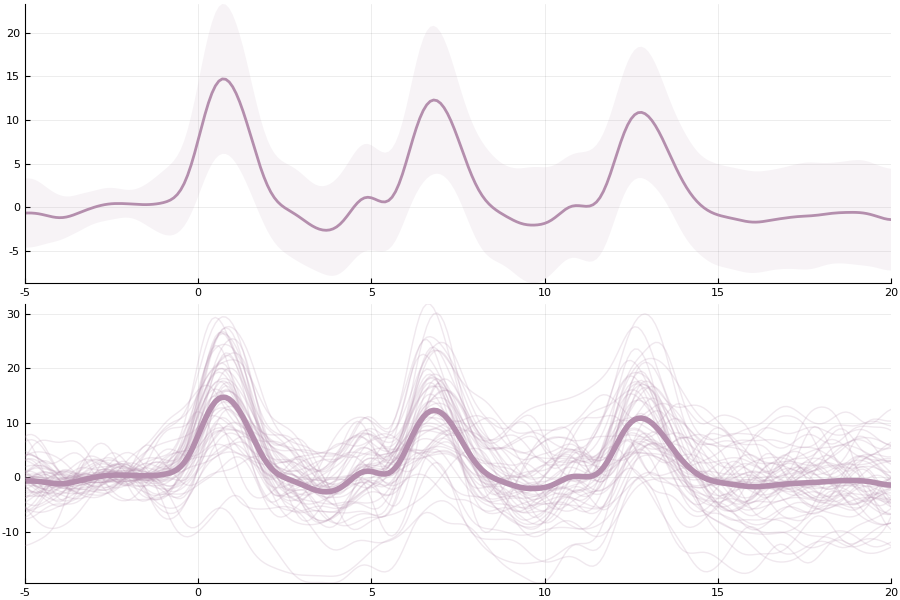

In [17]:
ABABA_color = nord[:aurora][5]
ABABB_color = nord[:aurora][4]

summary = plot(roi, mean(dx,2), ribbon=std(dx,2), fillalpha=0.1, linewidth=2, color=ABABA_color, legend=false);

plot(roi, mean(dx,2),fillalpha=0.1,linewidth=4, color=ABABA_color, legend=false);
ABABA = plot!(roi, dx, alpha=0.2, color=ABABA_color, legend=false);
plot(summary,ABABA,layout=(2,1), size=(900,600))

In [26]:
plt.vlines([1])

LoadError: [91mPyError (ccall(@pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, arg, C_NULL)) <class 'TypeError'>
TypeError("vlines() missing 2 required positional arguments: 'ymin' and 'ymax'",)
[39m

In [25]:
using PyCall
@pyimport matplotlib.pyplot as plt

In [27]:
plt

__anon__